# Dimentionality Reduction using PHATE

Prerequisites:
- You have preprocessed your data in the AnnData format into the data/preprocessed directory. [notebook: 0-data-preprocessing]: 
    - gene values on _X_ (adata.X)
    - phate embeddings of the data on _obsm_ (ex.: adata.obsm['X_phate])
    - any extra metadata on _obs_ (ex.: adata.obs['time'], adata.obs['disease_progression'], etc...)


In this notebook, we will:
- Use the preprocessed data to create a comntinuous latent space.
- This space will be created by running PHATE
- We will show how to interpret some of the phate parameters and how to choose a good representation of the space.

### Loading the data from _data\/processed_

Here we are loding the adata object from _.h5ad_ files

In [1]:
import phate
import scprep
import pandas as pd
import scanpy as sc

import os

data_name = 'cyclicEMT'
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed',data_name)

print(PROCESSED_DATA_DIR)

../../data/processed/cyclicEMT


In [2]:
adata = sc.read(os.path.join(PROCESSED_DATA_DIR, 'adata.h5ad'))
adata

AnnData object with n_obs × n_vars = 19400 × 60
    obs: 'time_label', 'cell_class', 'cell_cycle_label'

*_adata_* should have an *obs* field related to time and it's *_X_* must be the actual genes

<a id='pca'></a>
## 1. Embedding Data Using PCA

Here we need to embed our data into a lower dimentional space. This is necessary to allow MIOFlow to be computed quickly.

Working straight in PHATE space would be too slow, so we compute both PCA and PHATE. This allows us to compute distances on PCA space and regularize by PHATE.

For this we simply compute PCA from scanpy

In [3]:
n_components = 50
#This function will change adata inplace and add X_pca into adata.obsm
pca_df = sc.pp.pca(adata, n_comps=n_components)

In [4]:
adata

AnnData object with n_obs × n_vars = 19400 × 60
    obs: 'time_label', 'cell_class', 'cell_cycle_label'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

<a id='phate'></a>
## 1. Embedding Data Using PHATE

We are going to run PHATE over the lower dimensional PCA space. for the same reasons as explained above.

### 1.1 Instantiating the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `knn` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `decay` increases connectivity on the graph, increasing `decay` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE:

In [5]:
phate_operator = phate.PHATE(n_jobs=-2,n_components=2)

X_phate = phate_operator.fit_transform(adata.obsm['X_pca'])

# Here we add the X_phate to adata
# X_phate is the embedding of the data and can also be used for visualization

adata.obsm['X_phate'] = X_phate


Calculating PHATE...
  Running PHATE on 19400 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 5.74 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 5.90 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.65 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.71 seconds.
  Calculated landmark operator in 2.80 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 1.31 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.35 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.88 seconds.
Calculated PHATE in 12.23 seconds.


And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

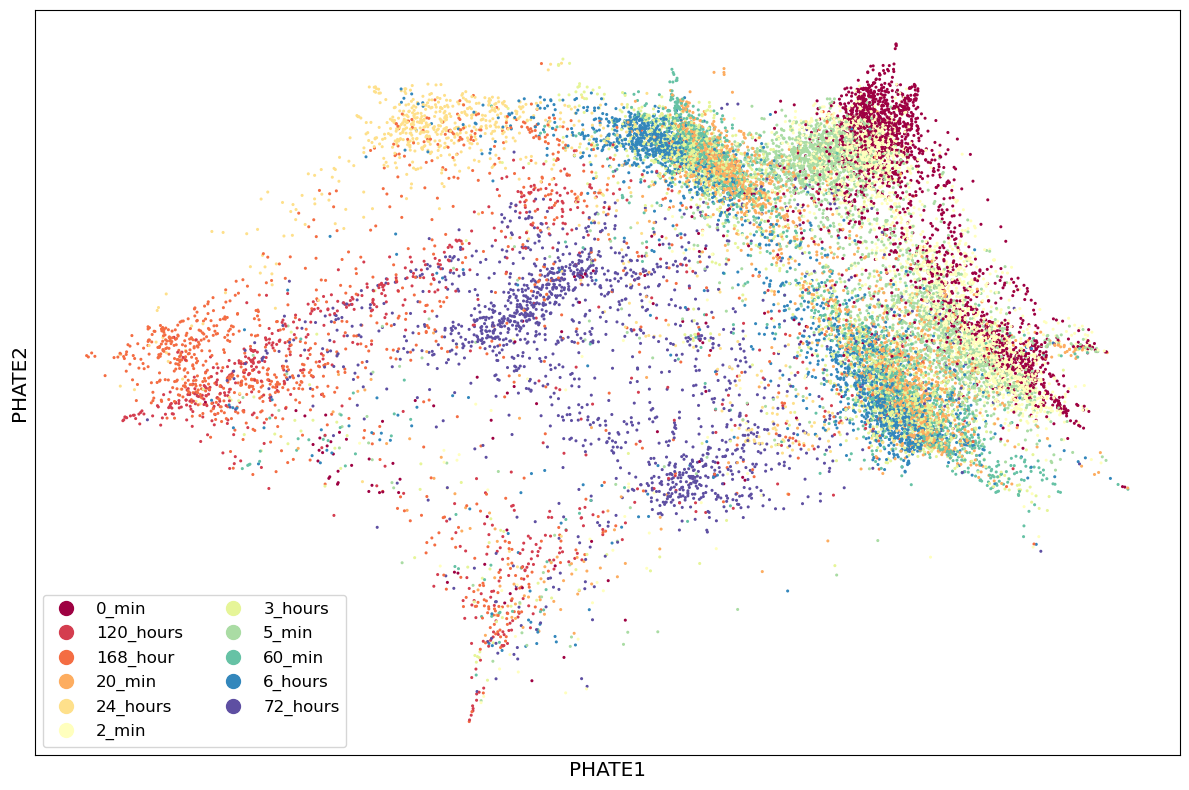

In [6]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['time_label'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

## Finaly we save the new _.h5ad_ object that contains:

- obs: 'time_label'
- uns: 'pca'
- obsm: 'X_pca', 'X_phate', 'X_phate_visualization'
- varm: 'PCs'


In [7]:
adata

AnnData object with n_obs × n_vars = 19400 × 60
    obs: 'time_label', 'cell_class', 'cell_cycle_label'
    uns: 'pca'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'

#### Saving the new object

In [8]:
adata.write(os.path.join(PROCESSED_DATA_DIR, 'adata_phate.h5ad'))